## XModalix Workbook

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

# notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# print(notebook_dir)
# os.chdir(notebook_dir)
# os.chdir("..")
# print(os.getcwd())


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### GLOBALS
**ATTENTION**
Be sure to have the appropriate files, or adjust paths and make your own config

In [2]:
IMGROOT = os.path.join("../data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("../data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("../data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
    checkpoint_interval=25,
	loss_reduction = "sum",
    class_param="early",
    epochs=100,
    pretrain_epochs=0,
	beta = 0.01,
	gamma= 3,
	delta_class= 0,
	delta_pair = 3,
	learning_rate=0.001,
	k_filter=1000,
	latent_dim=8,
    batch_size=32,
	anneal_pretraining=True,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
				scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=50,
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
				scaling = "MINMAX",
                translate_direction="from",
            ),
            # "RNA2": DataInfo(
            #     file_path=NUMFILE,
            #     data_type="NUMERIC",
            # ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

### Run Xmodalix with defined config
- .run() does not work yet, because we dont have a visualizer, so we run it step by step

In [3]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
xmodalix = acx.XModalix(config=img_config)
xmodalix.run()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='../data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=50
Checking data type: RNA
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: ../data/ALY-2_SYS721_mappings.txt
Successfully loaded 260 images for IMG
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'RNA': 260}, 'annotation': {'paired': 260, 'IMG': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}


/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)
/home/ewald/Github/autoencodix_package/src/autoencodix/data/_filter.py:92: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(


Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Check if we need to pretrain: multi_bulk.RNA
pretrain epochs : 0
No pretraining for multi_bulk.RNA
Check if we need to pretrain: img.IMG
pretrain epochs : 50
Starting Pretraining for: img.IMG with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 100504.7266
Sub-losses: recon_loss: 99954.0947, var_loss: 1212899294.2809, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 13638.6377
Sub-losses: recon_loss: 13638.6377, var_loss: 5.2719, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 83272.2529
Sub-losses: recon_loss: 82258.6104, var_loss: 1828080592.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 12924.3203
Sub-losses: recon_loss

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'total_loss': TrainingDynamics(), 'adver_loss': TrainingDynamics(), 'aggregated_sub_losses': TrainingDynamics(), 'paired_loss': TrainingDynamics(), 'class_loss': TrainingDynamics(), 'multi_bulk.RNA.recon_loss': TrainingDynamics(), 'multi_bulk.RNA.var_loss': TrainingDynamics(), 'multi_bulk.RNA.anneal_factor': TrainingDynamics(), 'multi_bulk.RNA.effective_beta_factor': TrainingDynamics(), 'multi_bulk.RNA.loss': TrainingDynamics(), 'img.IMG.recon_loss': TrainingDynamics(), 'img.IMG.var_loss': TrainingDynamics(), 'img.IMG.anneal_factor': TrainingDynamics(), 'img.IMG.effective_beta_factor': TrainingDynamics(), 'img.IMG.loss': TrainingDynamics(), 'clf_loss': TrainingDynamics()})
preprocessed

## Xmodalix Visualization

Creating plots ...


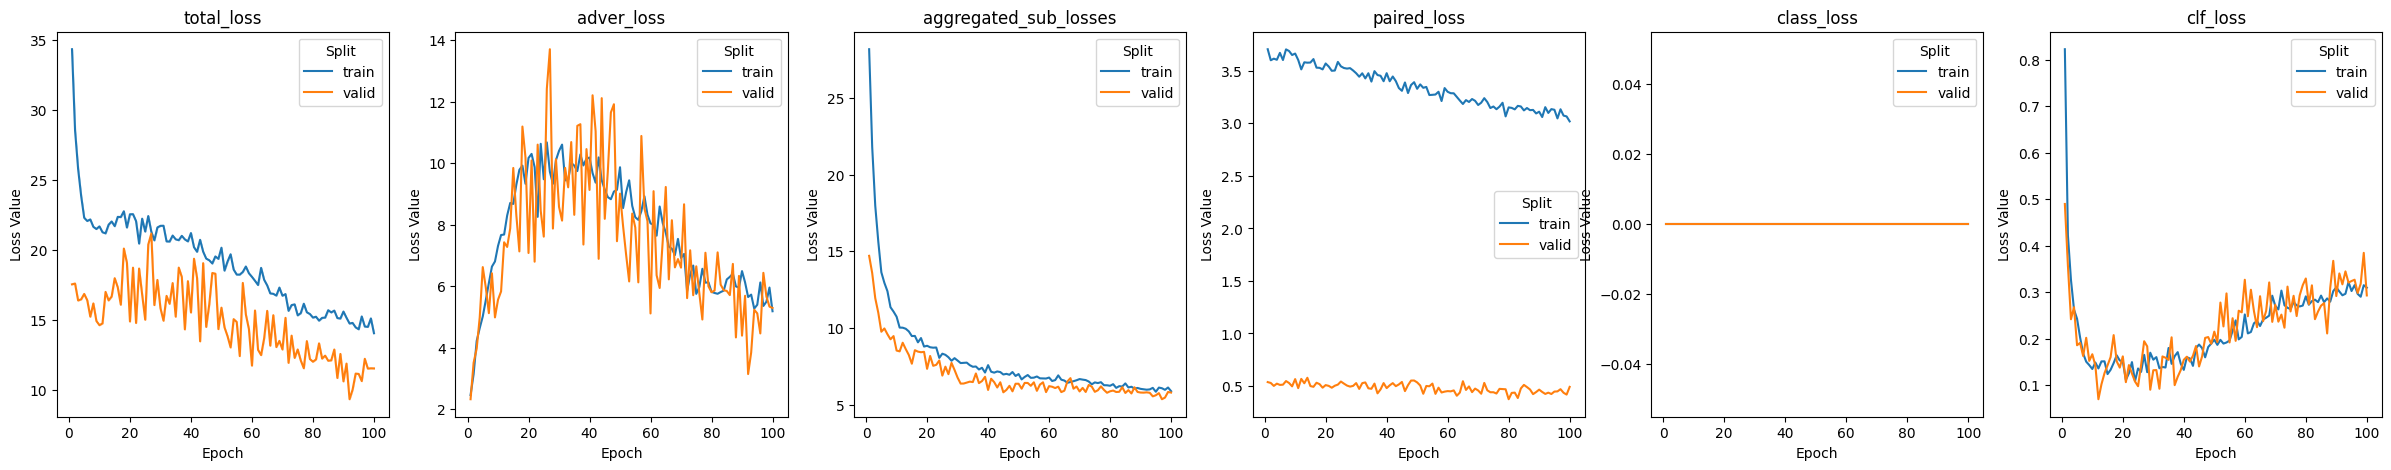

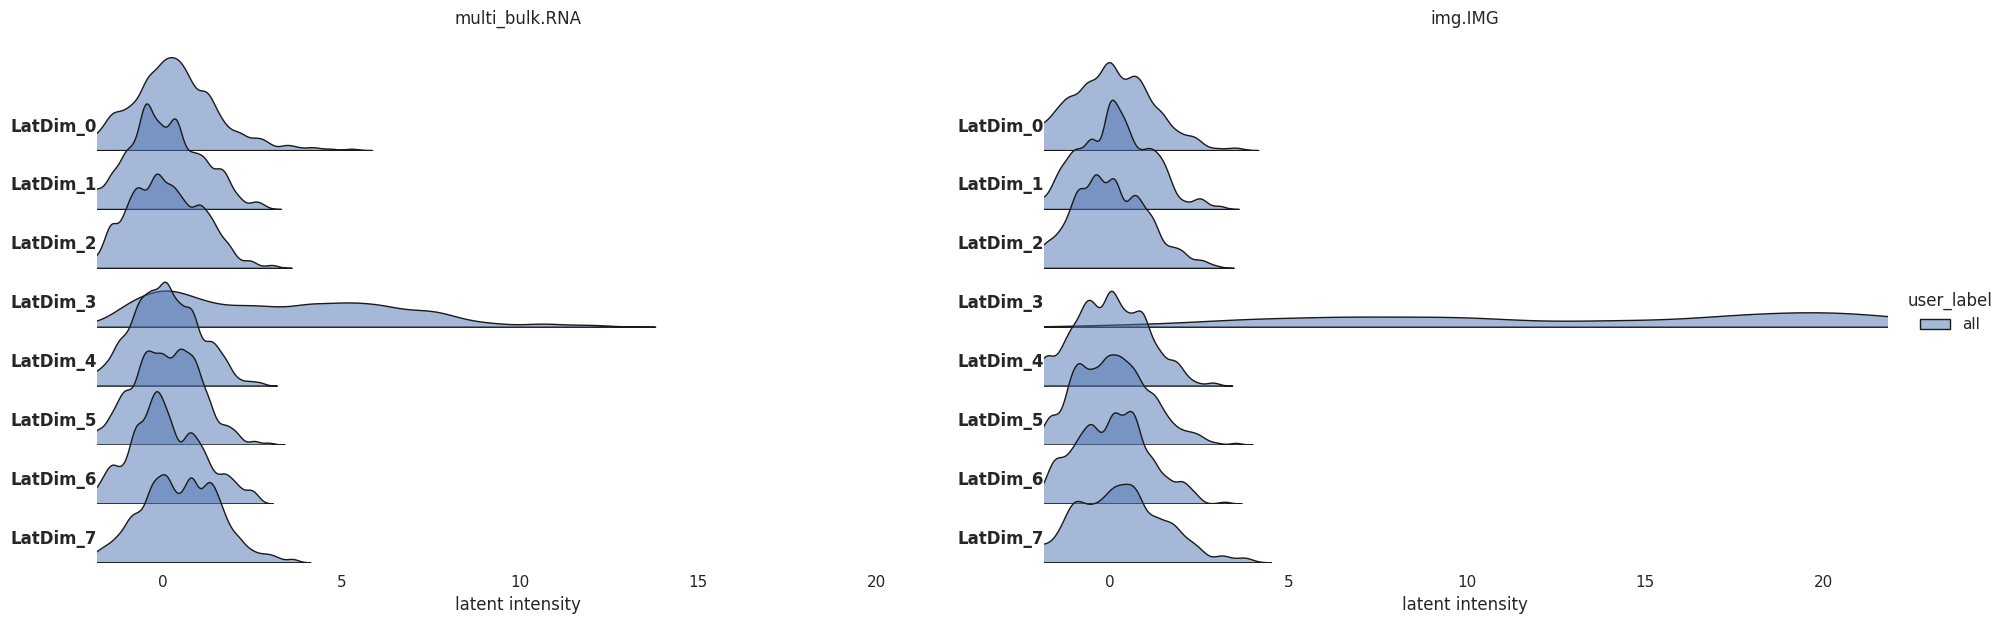

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


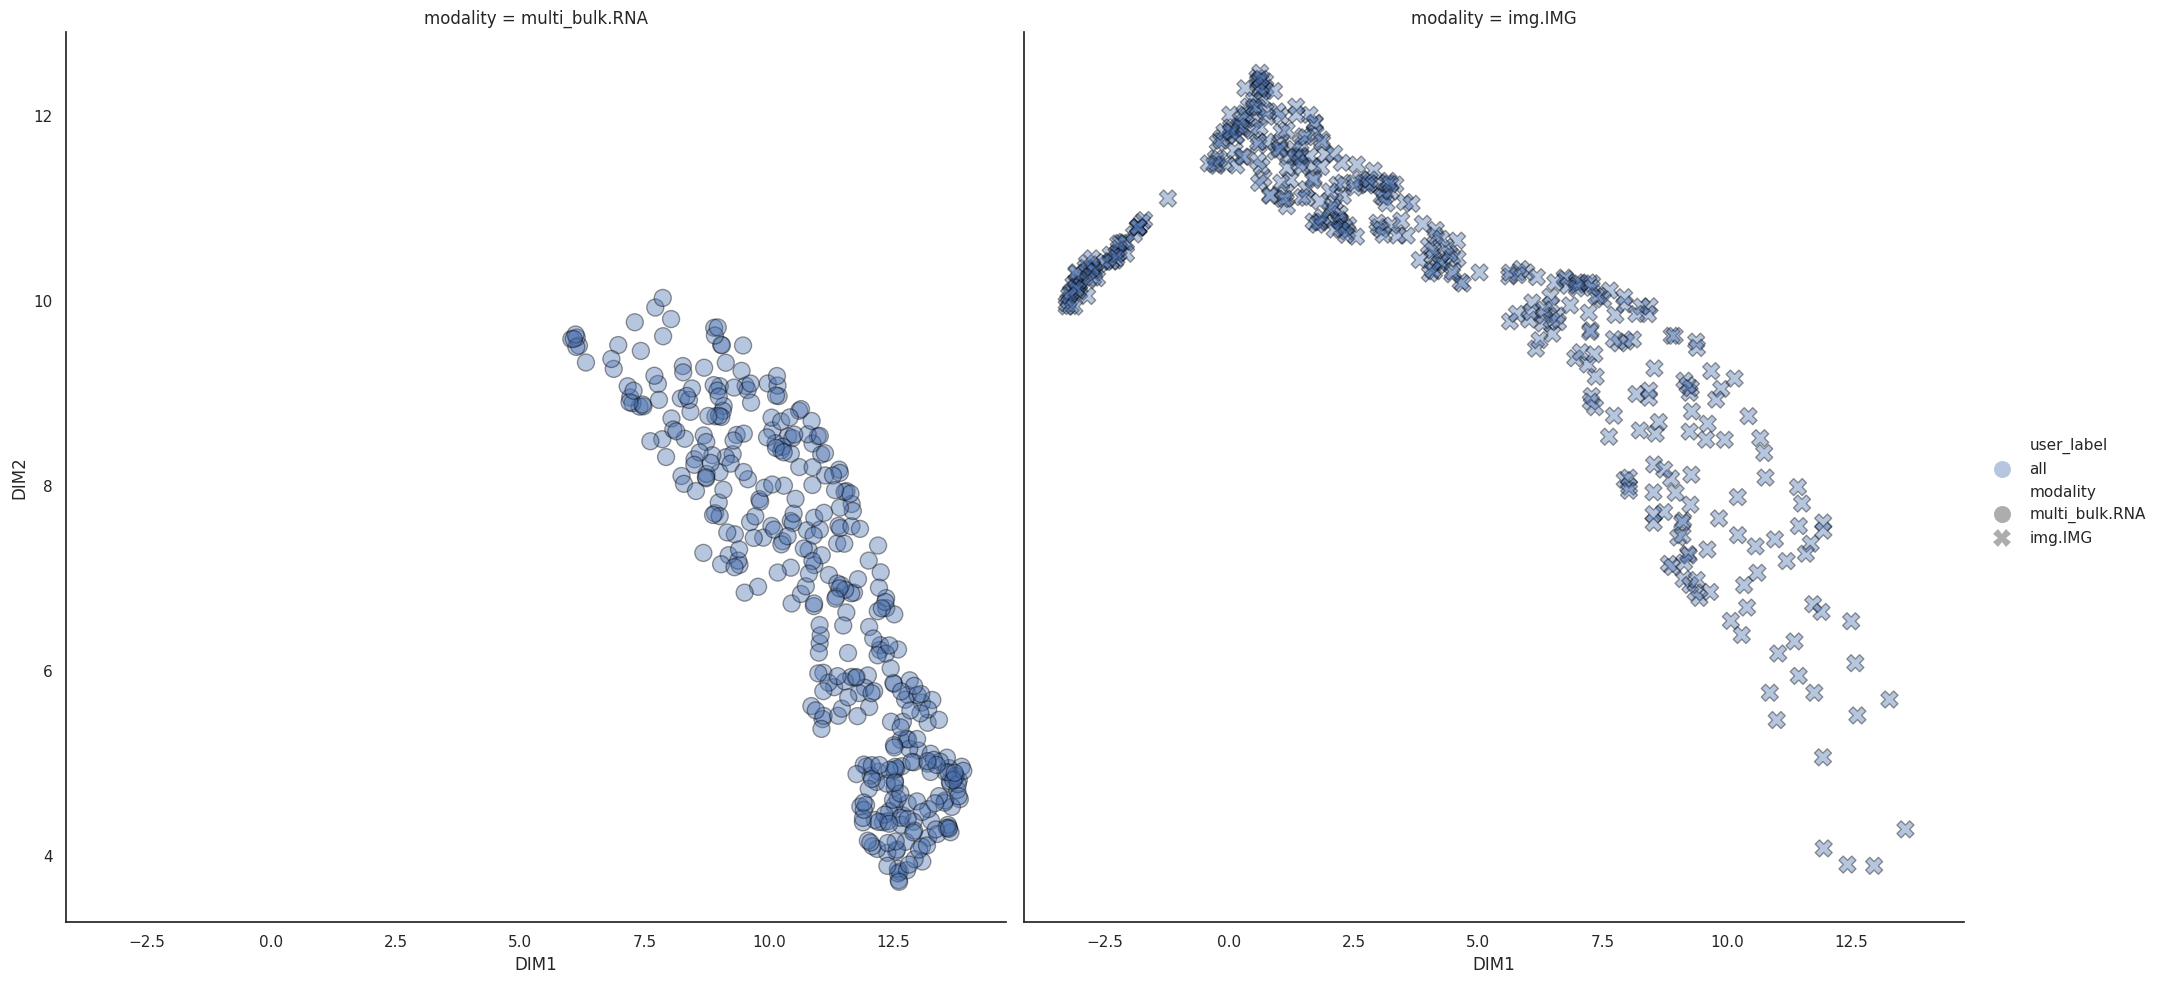

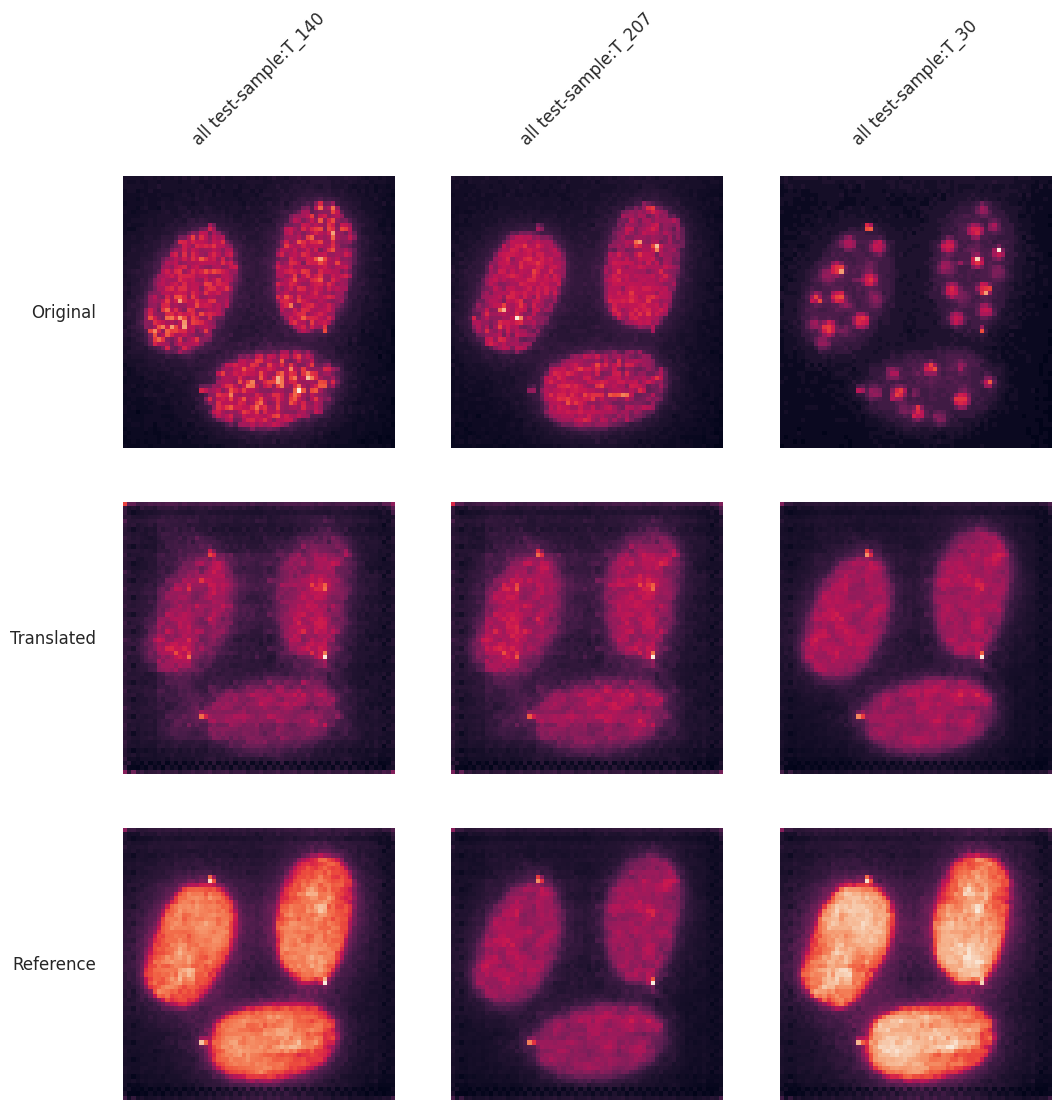

In [5]:
## Standard without class-info and metadata
xmodalix.show_result()

### Visualizations with class-info and metadata by user

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


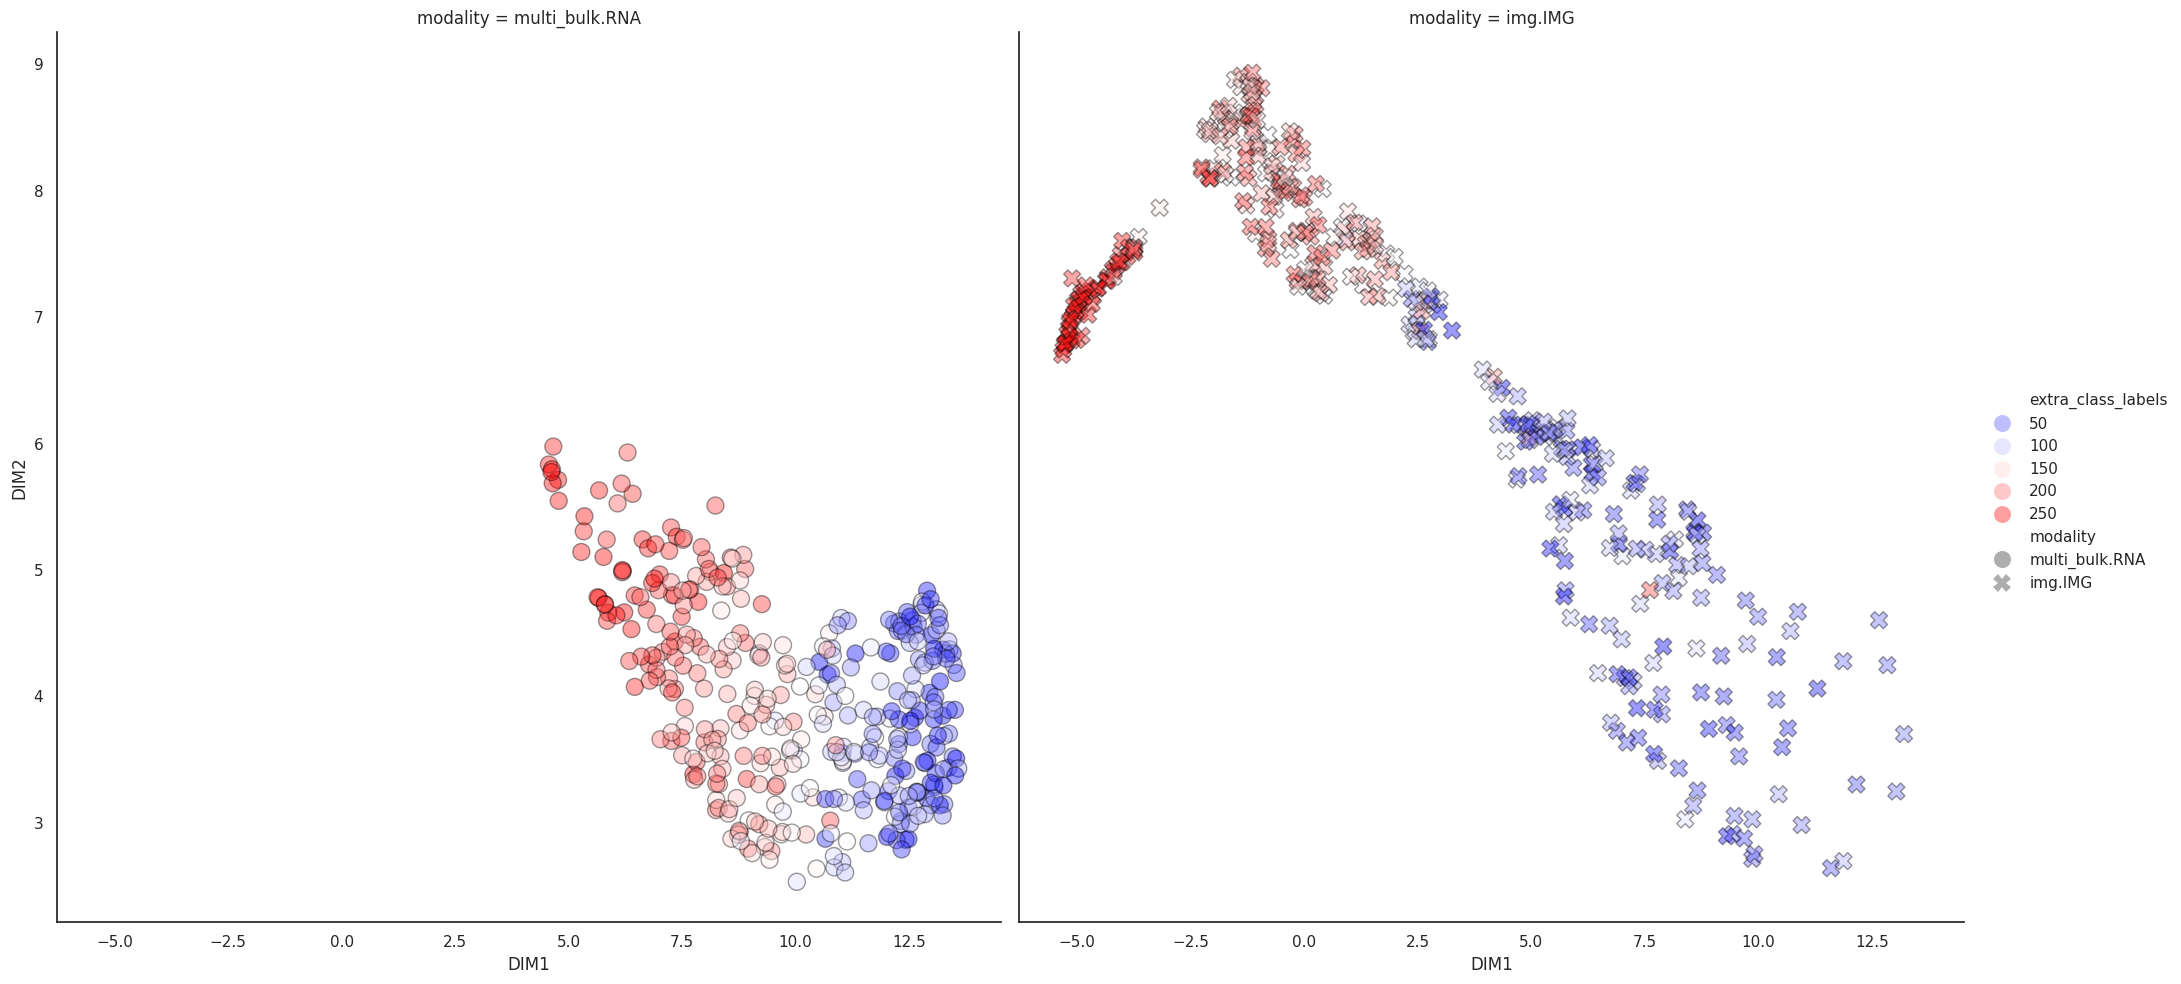

In [6]:
xmodalix._visualizer.show_latent_space(
	result=xmodalix.result,
	plot_type="2D-scatter",
	param=["extra_class_labels"]
)

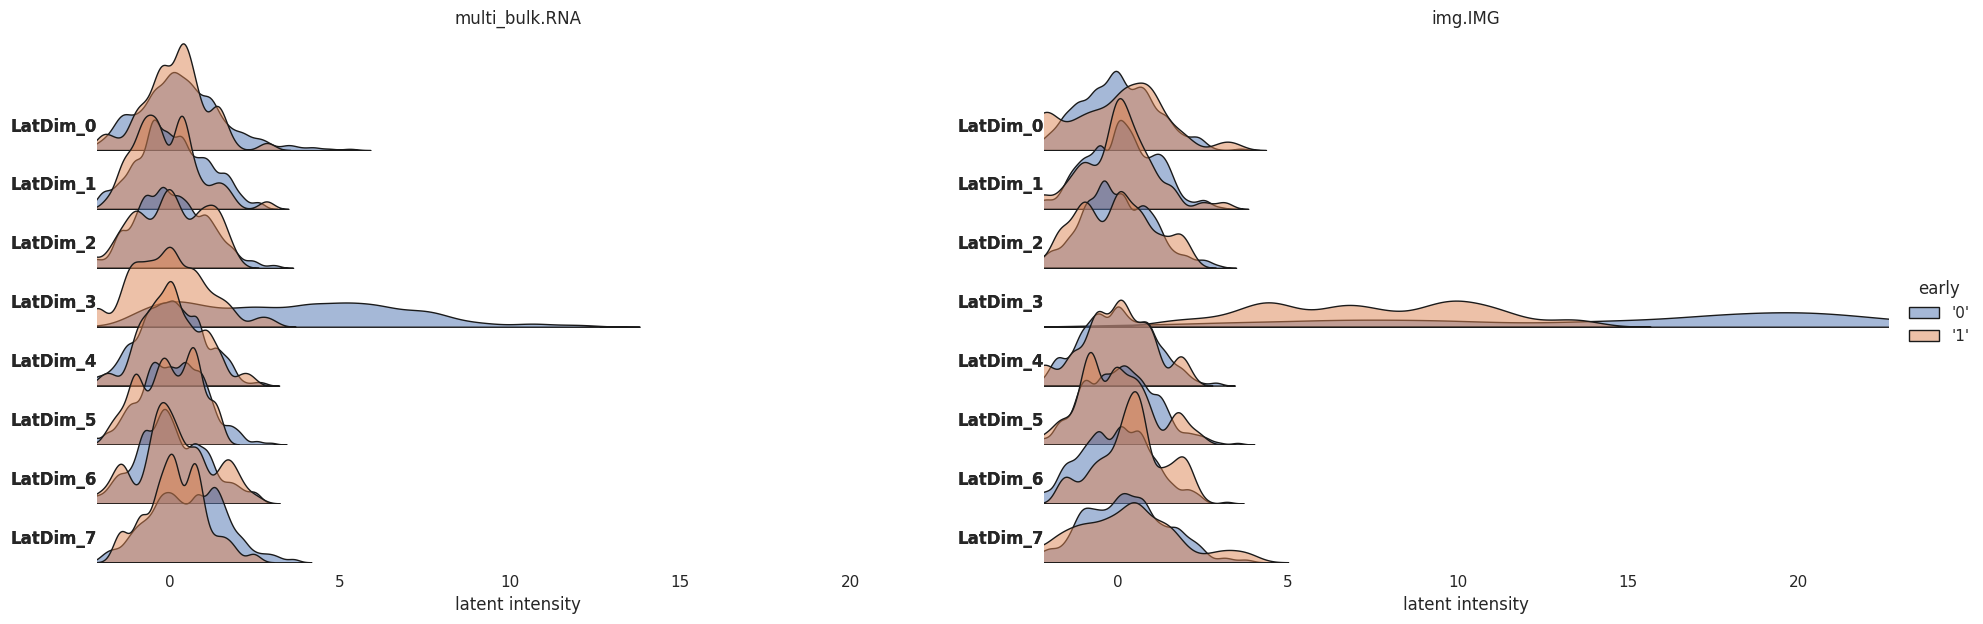

In [7]:
xmodalix._visualizer.show_latent_space(
	result=xmodalix.result,
	plot_type="Ridgeline",
	param=["early"]
)

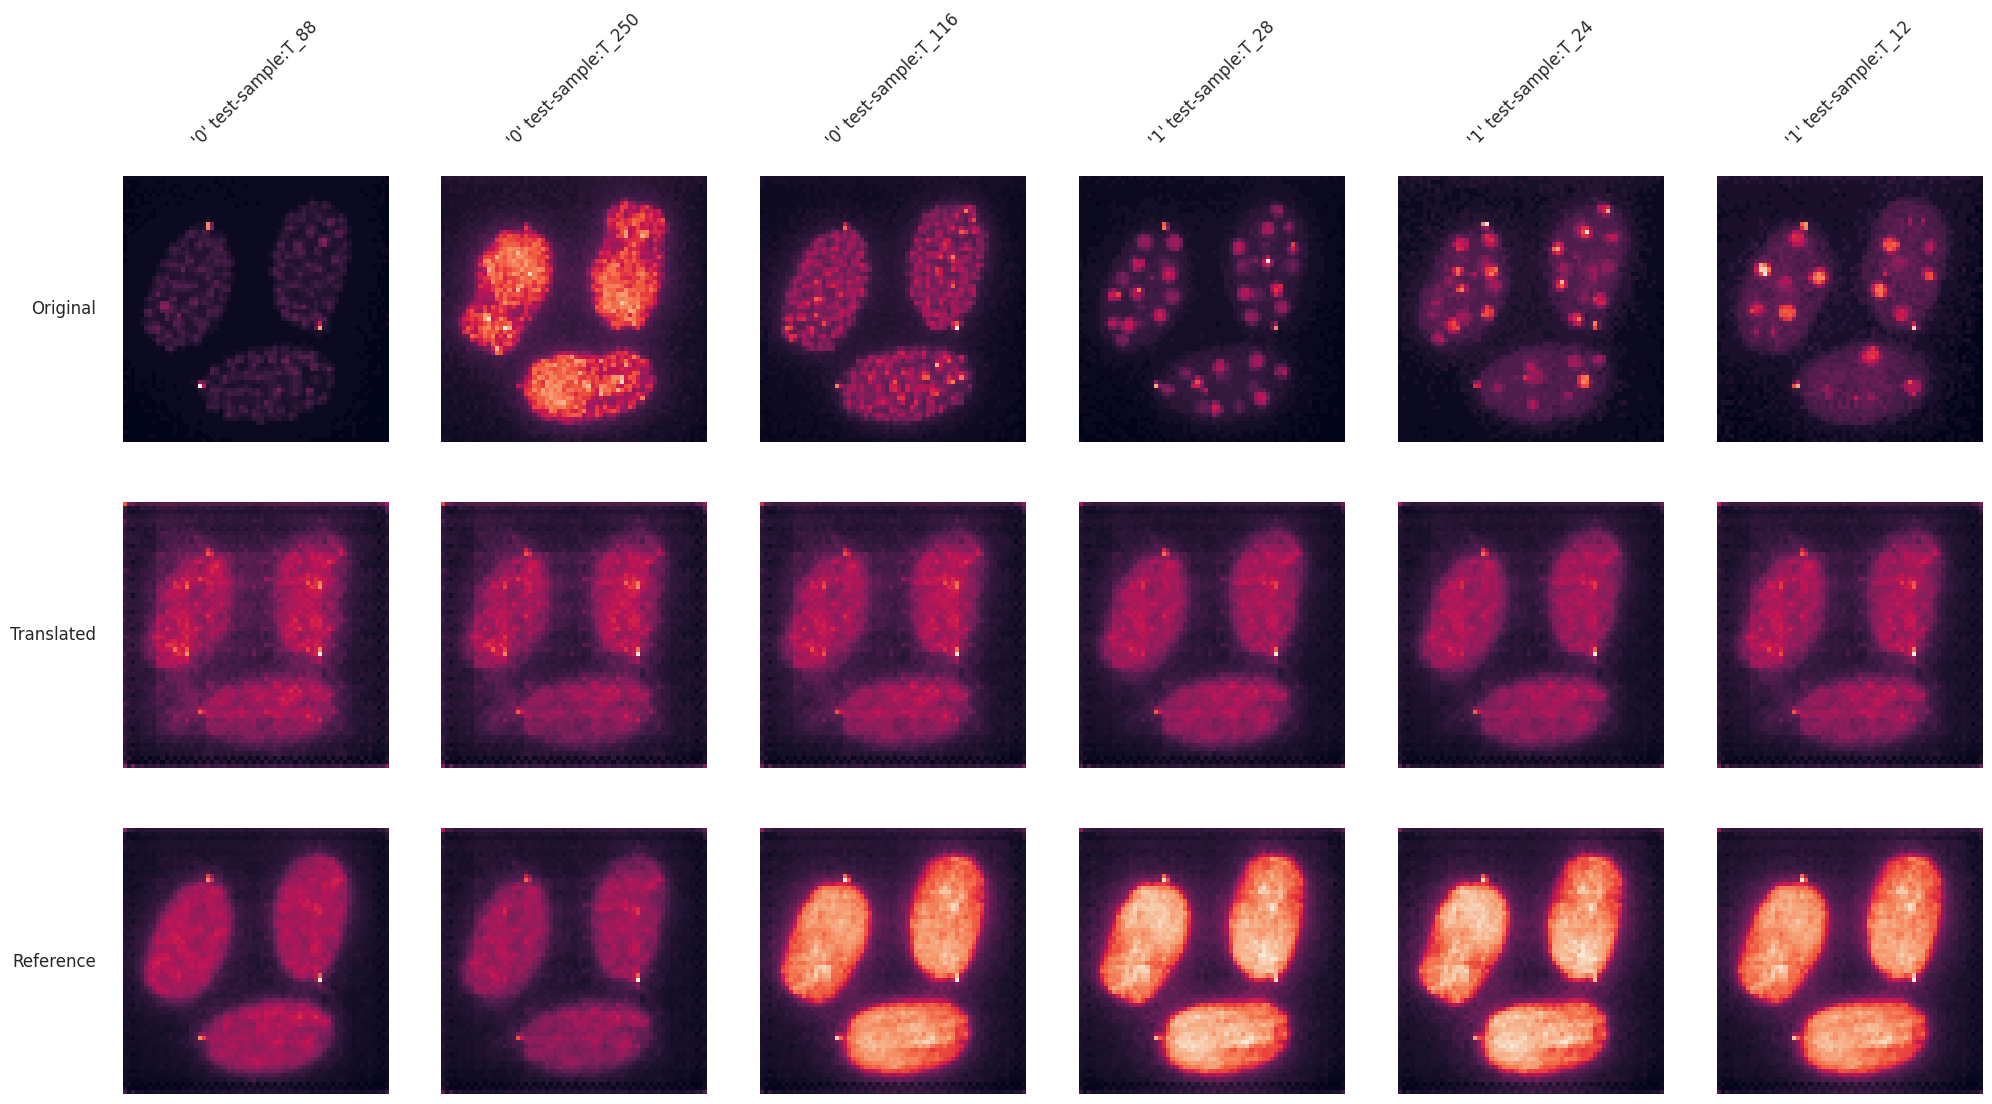

In [8]:
from autoencodix.utils._utils import find_translation_keys

dm_keys = find_translation_keys(config=xmodalix.config, trained_modalities=xmodalix._trainer._modality_dynamics.keys())

xmodalix._visualizer.show_image_translation(result=xmodalix.result, from_key=dm_keys["from"], to_key=dm_keys["to"], param="early")

In [9]:
## Weight Visualization not implemented for X-Modalix since quite complex and probably not used by anyone
# xmodalix._visualizer.show_weights()

## Architectures not stored as nn.module in xmodalix.result.model but as dictionaries:

# from autoencodix.modeling._varix_architecture import VarixArchitecture

# model = VarixArchitecture(config=img_config, input_dim=xmodalix.result.datasets.train.get_input_dim())
# model.load_state_dict(
# 	xmodalix.result.model_checkpoints.get(epoch=-1)['train']['multi_bulk.RNA']
# )
# model

### Loading and Saving XModalix
- works like for other pipelines too, can be used to run another predict pairing also

In [10]:
xmodalix.save("xmodalix.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.


In [11]:
xmodalix = acx.XModalix.load("xmodalix.pkl")

Attempting to load a pipeline from xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Model state loaded successfully.


### Inspect X-Modalix Result

In [12]:
r = xmodalix.result


Trainingdynamics in result are a dict with keys for each datamodality, the get interface works like for the other pipelines.
We have the special keys:
- translation which is the actual translated reconstruction or the from_latent space for the latentspace dynamic

In [13]:
r.reconstructions.get(epoch=-1, split="test").keys()

dict_keys(['multi_bulk.RNA', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])

We have latentspaces for the test set for each modality, not only for the translation pairing

In [14]:
r.latentspaces.get(epoch=-1, split="test")

{'multi_bulk.RNA': array([[ 7.00877547e-01, -1.49730182e+00, -2.79215634e-01,
          2.94527030e+00,  4.69345272e-01, -9.95618999e-01,
          6.73710555e-02,  2.41328418e-01],
        [-8.93461168e-01, -8.88280749e-01, -1.44903183e+00,
          7.04466915e+00, -1.38150156e-01,  7.98843861e-01,
          1.14990461e+00, -1.57879555e+00],
        [ 2.08899283e+00,  1.16774821e+00, -1.12996733e+00,
          7.77905130e+00,  7.99303830e-01, -1.56819856e+00,
         -5.56521535e-01, -1.24886048e+00],
        [ 5.10579407e-01, -6.05939627e-01,  1.14389920e+00,
         -1.41461372e-01,  1.51585889e+00, -1.47936380e+00,
          2.04867601e+00,  9.25414443e-01],
        [-3.00544202e-01, -9.89388168e-01, -9.43979204e-01,
         -5.52656949e-01, -5.51227212e-01,  2.24597827e-01,
         -1.83189407e-01, -8.75375688e-01],
        [-5.64678431e-01, -6.21307373e-01,  1.54816341e+00,
          1.79707694e+00,  6.60859466e-01, -4.94269043e-01,
          8.45652342e-01,  1.64424217e+00]

We also provide the andata interface for the translate latentspace (from_modality)

In [15]:
r.adata_latent.obs_names

Index(['T_153', 'T_226', 'T_254', 'T_20', 'T_27', 'T_118', 'T_80', 'T_101',
       'T_213', 'T_234', 'T_2', 'T_211', 'T_160', 'T_107', 'T_208', 'T_164',
       'T_92', 'T_223', 'T_90', 'T_9', 'T_146', 'T_196', 'T_166', 'T_16',
       'T_224', 'T_231', 'T_178', 'T_40', 'T_109', 'T_181', 'T_83', 'T_61',
       'T_38', 'T_130', 'T_77', 'T_29', 'T_153', 'T_254', 'T_226', 'T_46',
       'T_42', 'T_20', 'T_62', 'T_139', 'T_63', 'T_234', 'T_110', 'T_211',
       'T_160', 'T_45', 'T_50', 'T_198', 'T_223', 'T_90', 'T_146', 'T_224',
       'T_166', 'T_231', 'T_136', 'T_97', 'T_83', 'T_35', 'T_10', 'T_241',
       'T_188', 'T_159'],
      dtype='object')

And we also support the final_reconstruction attribute that returns the same datastructure as the input data, but switches the actual data with the translated reconstruction (for the translted modality, the rest is the same as the input data)

In [16]:
final_rec = r.final_reconstruction.datasets["img.IMG"]
inputimg = xmodalix.result.datasets.test.datasets["img.IMG"]

### Flexible Prediction
We train the Xmodalix with multiple data modalities, out of all these modalities, we can build any pair for translation byt passing the keys (as defined in your config or datapackage) to the predict method like:

In [17]:
result2 = xmodalix.predict(from_key="IMG", to_key="IMG")

Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.RNA'
  - Added 279 source feature IDs to .uns
Finished processing latent results.


### Inspecting losses
We save all losses in our result object, see the keys here:

In [18]:
r.sub_losses.keys()

dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.RNA.recon_loss', 'multi_bulk.RNA.var_loss', 'multi_bulk.RNA.anneal_factor', 'multi_bulk.RNA.effective_beta_factor', 'multi_bulk.RNA.loss', 'img.IMG.recon_loss', 'img.IMG.var_loss', 'img.IMG.anneal_factor', 'img.IMG.effective_beta_factor', 'img.IMG.loss', 'clf_loss'])

After selecting a subloss, this works like a standard TrainingDynamic

In [19]:
r.sub_losses.get("adver_loss")

TrainingDynamics()

### Visualizing a sample output
Note this is shown with only one epoch training, I've seen good results for 20 epochs of pretraining img and 30 epochs of normal training

In [20]:
img = r.reconstructions.get(split="test", epoch=-1)

In [21]:
img = img["translation"]

In [22]:
img.shape

(66, 1, 64, 64)

In [23]:
sample_img = img[0, :, :, :].squeeze()
sample_img.shape

(64, 64)

In [24]:
sample_img.max()

np.float32(0.6270078)

In [25]:
import matplotlib.pyplot as plt
plt.imshow(sample_img)

### Getting Info about pretraining
The pretraining is saved in sub_results in the result object

In [26]:
sub_res = r.sub_results
sub_res

{'multi_bulk.RNA': None,
 'img.IMG': None,
 'pretrain.img.IMG': Result Object Public Attributes:
 ------------------------------
 latentspaces: TrainingDynamics object
 sample_ids: TrainingDynamics object
 reconstructions: TrainingDynamics object
 mus: TrainingDynamics object
 sigmas: TrainingDynamics object
 losses: TrainingDynamics object
 sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
 preprocessed_data: Tensor of shape (0,)
 model: ImageVAEArchitecture
 model_checkpoints: TrainingDynamics object
 datasets: DatasetContainer(train=None, valid=None, test=None)
 new_datasets: DatasetContainer(train=None, valid=None, test=None)
 adata_latent: AnnData object with n_obs × n_vars = 0 × 0
 final_reconstruction: None
 sub_results: None
 sub_reconstructions: None
 embedding_evaluation: Empty DataFrame
 Columns: []
 Index: []}

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [27]:
import autoencodix as acx
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("../data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("../data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("../data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    checkpoint_interval=10,
	loss_reduction = "sum",
    epochs=100,
	beta = 0.01,
	learning_rate=0.001,
	latent_dim=8,
    batch_size=32,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
				scaling="MINMAX",
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

/home/ewald/Github/autoencodix_package/src/autoencodix/utils/default_config.py:460: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")
/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='../data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction=None pretrain_epochs=0
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: ../data/ALY-2_SYS721_mappings.txt
Successfully loaded 260 images for IMG
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'multi_bulk': 0}, 'annotation': {'IMG': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
Epoch 1 - Train Loss: 26084216

In [28]:
imagix.predict()
imagix.visualize()

Creating plots ...


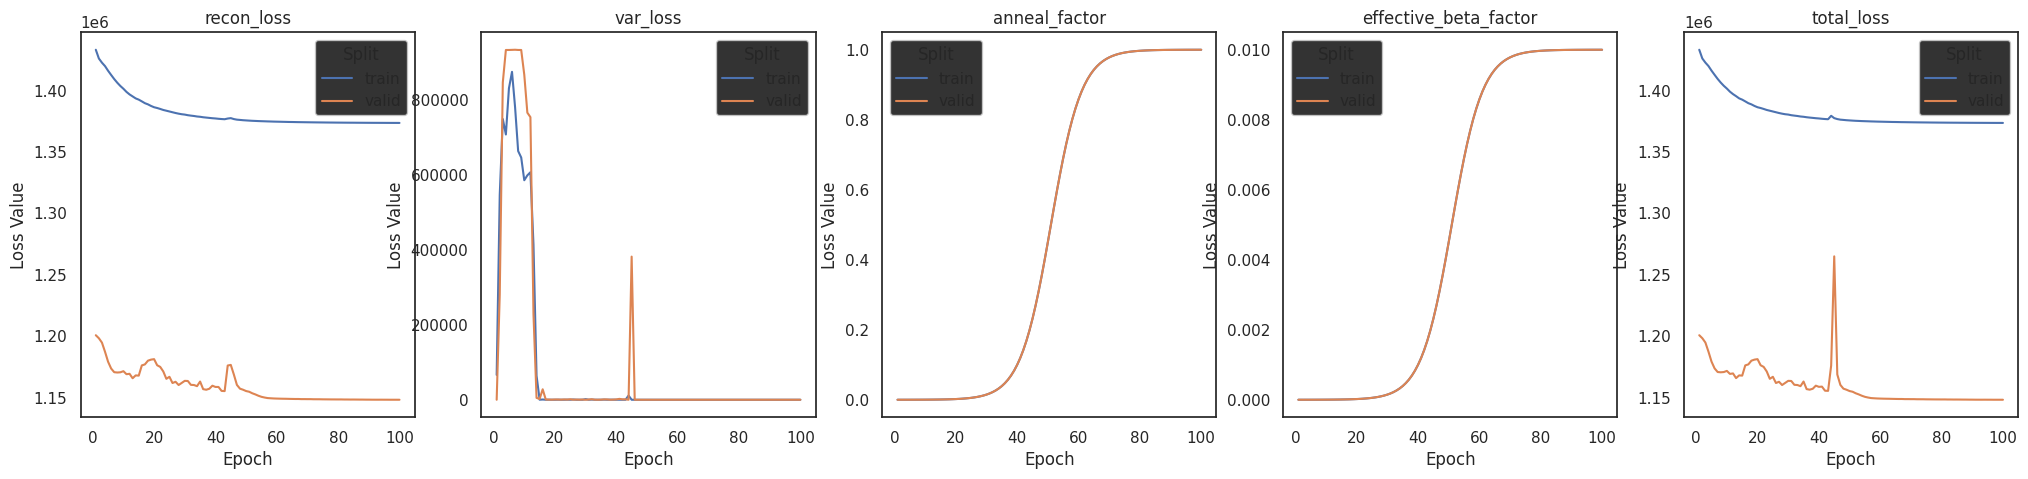

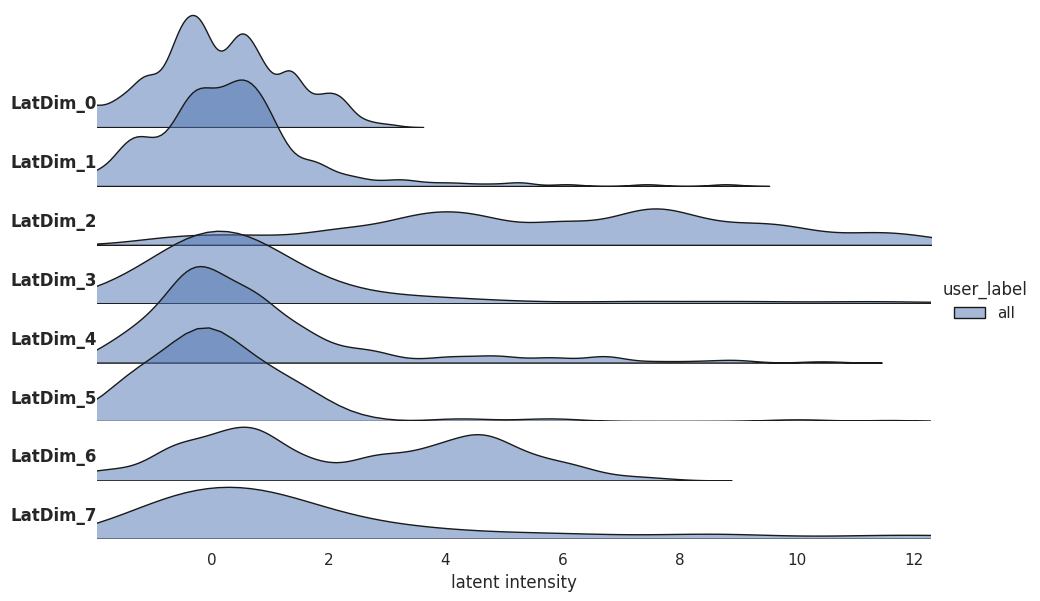

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


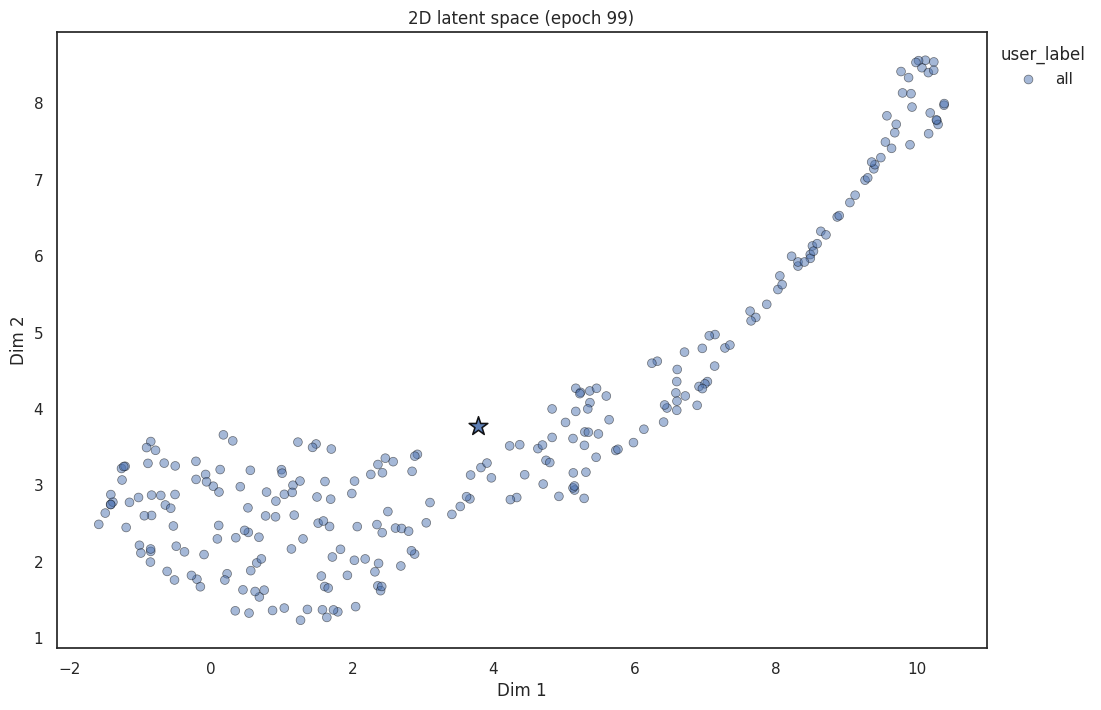

In [34]:

imagix.show_result()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


The provided label column is numeric and converted to categories.


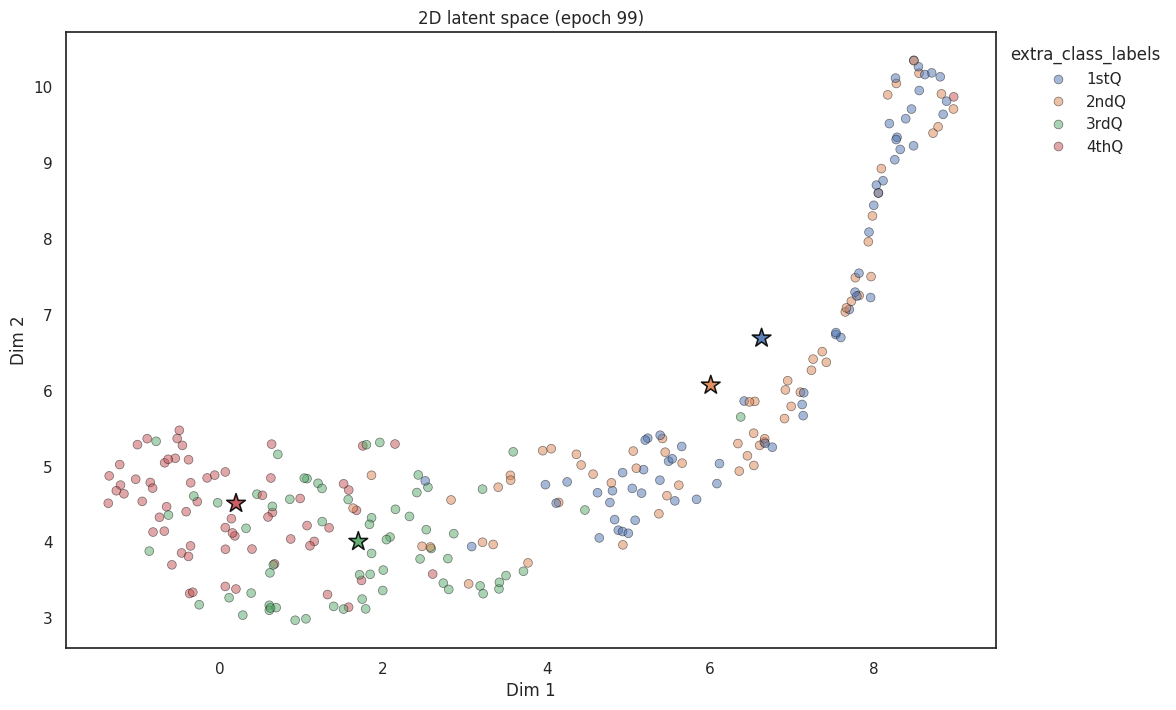

In [30]:
imagix._visualizer.show_latent_space(
		result=imagix.result,
		plot_type="2D-scatter",
		param=["extra_class_labels"],
	)

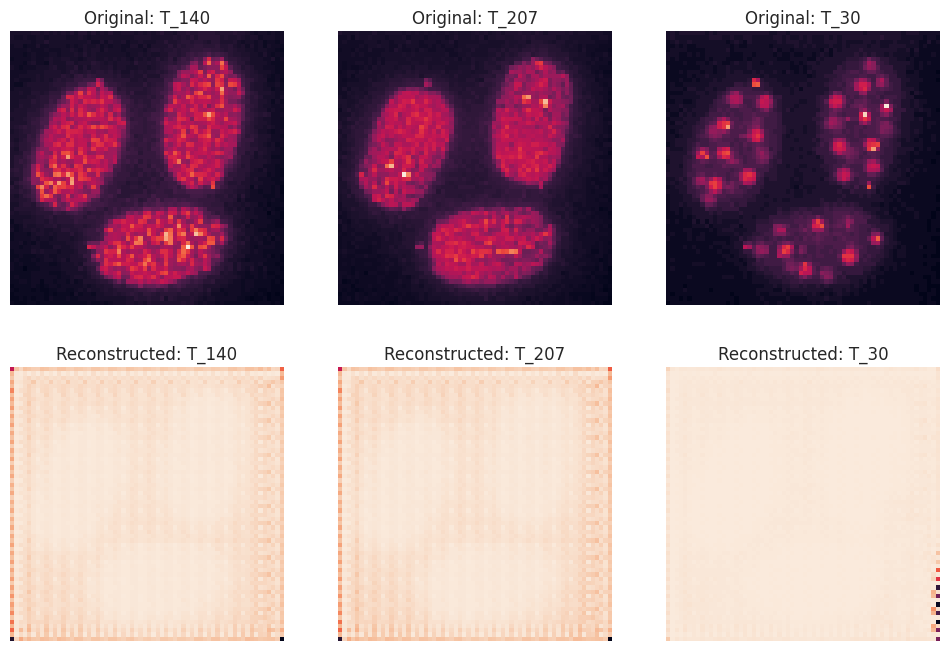

In [31]:
imagix._visualizer.show_image_recon_grid(result=imagix.result, n_samples=3)